In [1]:
# Cell 1: Imports & Parameters
import numpy as np
import pandas as pd
from pathlib import Path

import pvlib
from pvlib.iotools import read_epw
from pvlib.irradiance import get_total_irradiance
from pvlib.location import Location

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# 1) Paths & site info
project_root = Path.cwd().parent
epw_file     = project_root/"data"/"Bonfire_2025.epw"
assert epw_file.exists(), f"EPW not found: {epw_file}"

print("Using EPW:", epw_file)


Using EPW: /Users/petertunali/Documents/GitHub/Battery_Optimisation/data/Bonfire_2025.epw


In [2]:
# Cell 2: Load EPW & Precompute Solar Position
weather, meta = read_epw(epw_file)
lat, lon = -37.304286, 145.695693
tz       = 'Australia/Melbourne'
site     = Location(lat, lon, tz=tz)

times    = weather.index
solpos   = site.get_solarposition(times)
dni      = weather['dni']
ghi      = weather['ghi']
dhi      = weather['dhi']

delta_h = (times[1] - times[0]).total_seconds() / 3600.0
print(f"Loaded {len(times)} points; Δt = {delta_h:.2f} h")


Loaded 8760 points; Δt = 1.00 h


In [3]:
# Cell 3a: Coarse Grid-Search Tilt & Azimuth (every 10°)
tilts_coarse = np.arange(0, 91, 5)     # 0°, 5°, …, 90°
azis_coarse  = np.arange(0, 361, 10)   # 0°, 10°, …, 360°

records = []
for tilt in tqdm(tilts_coarse, desc="Coarse Tilts"):
    for azi in azis_coarse:
        poa = get_total_irradiance(
            surface_tilt    = tilt,
            surface_azimuth = azi,
            solar_zenith    = solpos["zenith"],
            solar_azimuth   = solpos["azimuth"],
            dni             = dni,
            ghi             = ghi,
            dhi             = dhi
        )["poa_global"]
        annual_kwh = (poa * delta_h / 1000.0).sum()
        records.append((tilt, azi, annual_kwh))

res_coarse = pd.DataFrame(records, columns=["tilt","azimuth","yield_kwh"])
best_coarse = res_coarse.loc[res_coarse["yield_kwh"].idxmax()]
print("▶ Coarse best tilt =", best_coarse.tilt,
      "°, azimuth =", best_coarse.azimuth,
      "°, yield ≈", f"{best_coarse.yield_kwh:.1f}", "kWh/kWp")


Coarse Tilts:   0%|          | 0/19 [00:00<?, ?it/s]

▶ Coarse best tilt = 30.0 °, azimuth = 20.0 °, yield ≈ 1726.0 kWh/kWp


In [4]:
# Cell 3b (Optional): Fine-Resolution around North with Isotropic Diffuse
tilts_fine = np.arange(best_coarse.tilt-5, best_coarse.tilt+6, 1)   # ±5° around coarse best
azis_fine  = np.arange(-30, 31, 1)   # 30° W → 30° E

records = []
for tilt in tqdm(tilts_fine, desc="Fine Tilts"):
    for azi in azis_fine:
        poa = get_total_irradiance(
            surface_tilt    = tilt,
            surface_azimuth = 180+azi,   # convert east-positive to pvlib’s 0=N,180=S
            solar_zenith    = solpos["zenith"],
            solar_azimuth   = solpos["azimuth"],
            dni             = dni,
            ghi             = ghi,
            dhi             = dhi,
            model           = 'isotropic'
        )["poa_global"]
        annual_kwh = (poa * delta_h / 1000.0).sum()
        records.append((tilt, azi, annual_kwh))

res_fine = pd.DataFrame(records, columns=["tilt","azi_offset","yield_kwh"])
best_fine = res_fine.loc[res_fine["yield_kwh"].idxmax()]
print("▶ Fine best tilt =", best_fine.tilt,
      "°, azimuth offset =", best_fine.azi_offset,
      "° E of north, yield ≈", f"{best_fine.yield_kwh:.1f}", "kWh/kWp")


Fine Tilts:   0%|          | 0/11 [00:00<?, ?it/s]

▶ Fine best tilt = 25.0 °, azimuth offset = -30.0 ° E of north, yield ≈ 1314.2 kWh/kWp


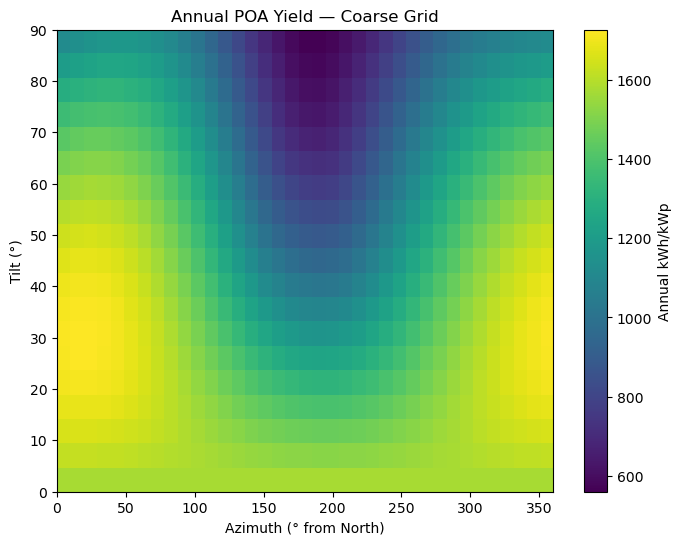

In [5]:
# Cell 4: Heatmap of Coarse Results
heat = res_coarse.pivot(index="tilt", columns="azimuth", values="yield_kwh")
plt.figure(figsize=(8,6))
plt.imshow(heat, origin="lower", aspect="auto",
           extent=[azis_coarse.min(), azis_coarse.max(),
                   tilts_coarse.min(), tilts_coarse.max()])
plt.colorbar(label="Annual kWh/kWp")
plt.xlabel("Azimuth (° from North)")
plt.ylabel("Tilt (°)")
plt.title("Annual POA Yield — Coarse Grid")
plt.show()


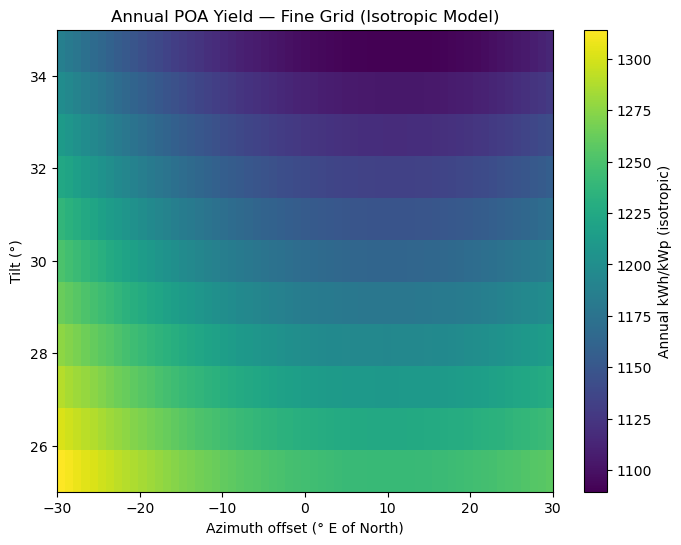

In [6]:
# Cell 5: Heatmap of Fine Results (Optional)
heat_f = res_fine.pivot(index="tilt", columns="azi_offset", values="yield_kwh")
plt.figure(figsize=(8,6))
plt.imshow(heat_f, origin="lower", aspect="auto",
           extent=[azis_fine.min(), azis_fine.max(),
                   tilts_fine.min(), tilts_fine.max()])
plt.colorbar(label="Annual kWh/kWp (isotropic)")
plt.xlabel("Azimuth offset (° E of North)")
plt.ylabel("Tilt (°)")
plt.title("Annual POA Yield — Fine Grid (Isotropic Model)")
plt.show()
